<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99d_insurance_federated_wrapup_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

Open

- [ ] 5 features (no region) centralized
- [ ] FLutils harmonize formats etc
- [ ] harmonize eval sizes
- [ ] test: optimization of mae vs mse?
- [ ] in FL: more epochs and less rounds -> improved performance? Or less epochs to avoid overfitting of the clients
- [x] document all input and outputs in FLutils
- [x] test colab
- [ ] ~~RSquared for FL, but it is only available in tf-nightly and the installation broke the env~~

## Prerequisites
---

### Libraries
---

In [1]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or possibly !pip install -r requirements.txt

    os.chdir("_dev")



COLAB? False


In [2]:
!python --version
# tested 3.9.* or 3.10.*.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [3]:
# show library versions
# =========================
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)


tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [4]:
# suppress tf debug logging
# =========================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [5]:
# imports
# =======

# basics: data, calculations and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tensorflow (federated) and keras
import tensorflow_federated as tff
import tensorflow as tf
from keras.callbacks import CSVLogger

# model selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

# statusbar for loops
import tqdm

# helper functions
from FLutils import (
    load_df,               # load data
    create_keras_model,    # construct a deep neural network (keras)
    model_fn,              # convert keras model to tff.learning.models
    prep_fed_train,        # convert training data to tensors for learning with tensorflow
    prep_fed_test,         # convert test data to tensors for testing with tensorflow (other format than training data)
    train_model,           # train a keras model
    train_fed              # train a keras model federated with distributed data
    )


In [6]:
# output path for logging
# =======================
out_path = '../output/experiments' 

### Data preperation
---

In [7]:
# ingest data
# ===========

df_paths = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_paths)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [8]:
df.shape

(1338, 11)

In [9]:
# select features, target (first column) and clients
# ==================================================

# features for centralized learning
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']

target = 'charges'

# features for federated learning
features_fed = features[:5]

# clients for data splits
clients = df.region.unique()

# show target + features in the data
df.loc[:, [target] + features ].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Budget
---

#### Evaluation

For fast explorations the budget can be reduced significantly. Recommended are

- `nreps = 1`: only one rep is required
- `nfolds` > 3: at least 3 cross validation folds to have enough training data
- `n_epochs`, `n_epochs_fed`, `n_rounds_fed`: can for technical test be very small (~ 10). For methodological test at least 50-100 iterations are needed to show the resulting performance, e.g. `n_epochs` > 60 or `n_epochs_fed` + `n_rounds_fed` > 60

In [10]:
# create evaluation splits
# ========================

nreps, nfolds = 5, 5
evaluation = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)


#### Training

In [11]:
n_epochs     = 100 # epochs (centralized training)
n_epochs_fed =  50 # epochs for each client in one server iteration (federated training)
n_rounds_fed =  50 # federated training rounds including distribution to the clients and aggregation of the results 

### Model
---

In [12]:
# define model architecture
# =========================

def keras_blueprint(compile = False, nfeatures = len(features_fed)):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [30, 30, 15], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note 1: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
#   S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras
# Note 2: this function has to generate a new instance of a keras_model 
#   to be useable for generating a federated learning process
# Note 3: loss = mae -> overfitting?

# show the model specifics
keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                180       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

### Federated Process
---

The federated training process is constructed from a keras model in the function `train_fed`. See `help(train_fed)`.

The generated default process is:

In [13]:
tff_process = tff.learning.algorithms.build_weighted_fed_avg(
	model_fn(
		keras_creator = keras_blueprint,
		loss = tf.losses.MeanSquaredError()
	),
	client_optimizer_fn = lambda: tf.optimizers.Adam(learning_rate = .05),
	server_optimizer_fn = lambda: tf.optimizers.Adam(learning_rate = .05)
 )

print(tff_process.initialize.type_signature.formatted_representation())


( -> <
  global_model_weights=<
    trainable=<
      float32[5,30],
      float32[30],
      float32[30,30],
      float32[30],
      float32[30,15],
      float32[15],
      float32[15,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[5,30],
    float32[5,30],
    float32[30],
    float32[30],
    float32[30,30],
    float32[30,30],
    float32[30],
    float32[30],
    float32[30,15],
    float32[30,15],
    float32[15],
    float32[15],
    float32[15,1],
    float32[15,1],
    float32[1],
    float32[1]
  >
>@SERVER)


## Federated Learning
---

In [14]:
experiment_name = '08_federated_small_dnn'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### FED Train 
---

In [15]:
# compute train
# =============

results_fed = []

eval_ind = 0#nfolds*7#0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))[:]):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # distribute train (and eval) data over the client and prep tensors.
    train_data_fed = []
    eval_data_fed  = []   
    for client in clients:
        outer_train_data_client = df[(df.index.isin(train)) & (df.region == client)]
        train_data_client, eval_data_client = train_test_split(outer_train_data_client, test_size = 0.1, random_state = 42)
        
        train_data_fed.append(
            prep_fed_train(train_data_client[features_fed], train_data_client[target])) 
        eval_data_fed.append(
            prep_fed_test(eval_data_client[features_fed], eval_data_client[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result =  train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        NUM_ROUNDS = n_rounds_fed,
        NUM_EPOCHS = n_epochs_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )
    
    # save history
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    # save model
    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    # Note: load with e.g. 
    #   model = keras_blueprint(compile = True)
    #   model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    #   model.weights

    results_fed.append(result)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [09:54<00:00, 23.78s/it]


In [16]:
# show train result
# =======================
table = pd.DataFrame([res['history'][-1] for res in results_fed])
table.to_csv(experiment_path + "results/performance_train.csv", sep = ";")
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,25.00,25.00,25.00,25.0,25.00,25.00,25.0,25.0,25.0,25.0
mean,2760.32,21752488.00,21777986.00,48120.0,378.20,4199.47,29401872.0,29489086.0,108.0,4.0
std,112.05,1431014.25,1411474.38,25.0,0.41,399.96,5822236.0,5730612.5,0.0,0.0
min,2516.71,18497750.00,18570358.00,48100.0,378.00,3332.04,17406428.0,17661536.0,108.0,4.0
25%,2679.68,20909032.00,20797930.00,48100.0,378.00,3951.27,25805850.0,25838526.0,108.0,4.0
50%,2773.68,22149012.00,22174554.00,48100.0,378.00,4171.48,28656472.0,28995684.0,108.0,4.0
75%,2826.58,22745094.00,22781120.00,48150.0,378.00,4454.71,32160826.0,31973756.0,108.0,4.0
max,3020.44,24592512.00,24520170.00,48150.0,379.00,5043.76,40804736.0,40258328.0,108.0,4.0


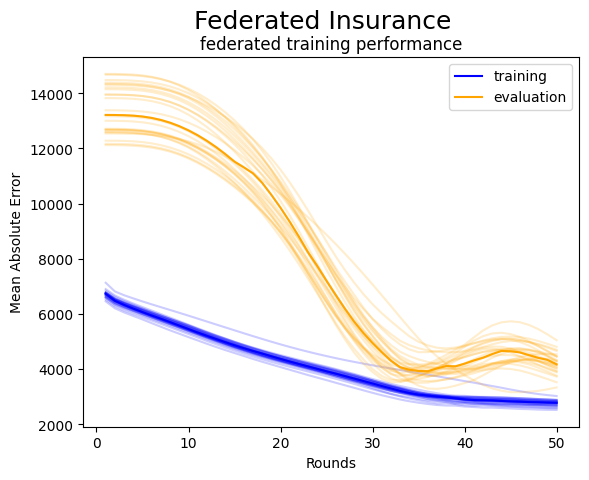

In [17]:
# plot train result (MAE)
# =======================
y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

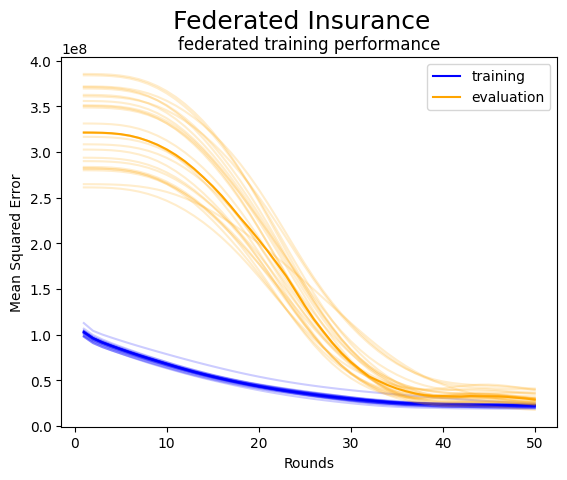

In [18]:
# plot train result (MSE)
# =======================

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test
---

In [19]:
# calculate test
# ==============
results_fed_test = []

model = keras_blueprint(compile = True)

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    X_test, y_test = data_test[features_fed], data_test[target]
    
    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    i += 1
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:14<00:00,  1.75it/s]


In [20]:
# show test results
# =================
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.to_csv(experiment_path + "results/performance_test.csv", sep = ";")
table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all_fed = pd.concat([table, table2], axis = 1)
table_all_fed.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_fed.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all_fed.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,2.760321e+03,1.120518e+02,2.516705e+03,2.679685e+03,2.773681e+03,2.826579e+03,3.020440e+03
mean_squared_error,2.175249e+07,1.431014e+06,1.849775e+07,2.090903e+07,2.214901e+07,2.274509e+07,2.459251e+07
loss,2.177799e+07,1.411474e+06,1.857036e+07,2.079793e+07,2.217455e+07,2.278112e+07,2.452017e+07
num_examples,4.812000e+04,2.500000e+01,4.810000e+04,4.810000e+04,4.810000e+04,4.815000e+04,4.815000e+04
num_batches,3.782000e+02,4.082000e-01,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02,3.790000e+02
val_mean_absolute_error,4.199472e+03,3.999616e+02,3.332044e+03,3.951266e+03,4.171480e+03,4.454713e+03,5.043762e+03
val_mean_squared_error,2.940187e+07,5.822236e+06,1.740643e+07,2.580585e+07,2.865647e+07,3.216083e+07,4.080474e+07
val_loss,2.948909e+07,5.730612e+06,1.766154e+07,2.583853e+07,2.899568e+07,3.197376e+07,4.025833e+07
val_num_examples,1.080000e+02,0.000000e+00,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

### Setup
---

Using 9 Features.

In [21]:
experiment_name = '09_central_small_dnn'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [22]:
# calculate training
# ==================
results_ctr = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))
    
    
    data_train = df.loc[train]
    X_train, y_train = data_train[features], data_train[target]

    model = keras_blueprint(nfeatures = len(features), compile = True)
    
    result = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        #output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42,
        verbose = False
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(result)


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [16:11<00:00, 38.87s/it]


In [23]:
# show train results
# ==================
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    #r2_score    = lambda x: x.r2_score * 100,
    #val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,21716544.0,2744.56,21716544.0,0.84,28420984.0,2924.24,28420984.0,0.82
1,20266144.0,2564.77,20266144.0,0.86,20541918.0,2811.11,20541918.0,0.85
2,23638624.0,2918.63,23638624.0,0.84,28104536.0,3023.17,28104536.0,0.83
3,21453998.0,2786.53,21453998.0,0.84,26216562.0,2880.38,26216562.0,0.84
4,21679396.0,2682.35,21679396.0,0.84,23235704.0,2846.41,23235704.0,0.85
5,21647238.0,2869.82,21647238.0,0.85,29726886.0,3457.62,29726886.0,0.81
6,19770526.0,2644.46,19770526.0,0.86,24314482.0,2758.40,24314482.0,0.85
7,19339324.0,2647.34,19339324.0,0.86,19413838.0,2784.50,19413838.0,0.86
8,22892080.0,2639.42,22892078.0,0.84,30953244.0,3925.04,30953244.0,0.80
9,24546380.0,2773.37,24546380.0,0.83,23720152.0,2925.38,23720152.0,0.84


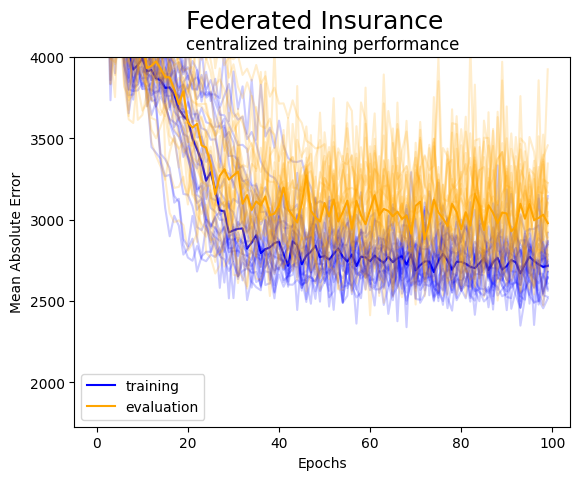

In [24]:
# plot train result (MAE)
# =======================
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


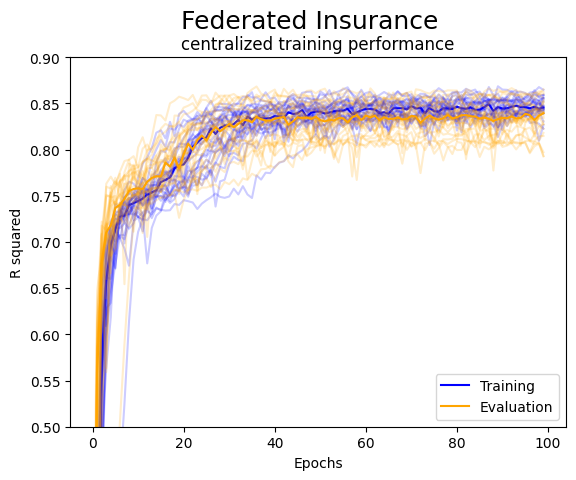

In [25]:
# plot train result (RSQ)
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [26]:
# compute test
# ============
results_test_ctr = []

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    
    X_test, y_test = data_test[features], data_test[target]
    
    
    model = results_ctr[i].model
    i += 1
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


In [27]:
# show test results
# =================
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all_ctr = pd.concat([table, table2], axis = 1)
table_all_ctr.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_ctr.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all_ctr.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,21677316.00,1304037.00,19339324.00,20595324.00,21679396.00,22478328.00,24546380.00
mae,2728.48,139.49,2515.95,2644.46,2717.27,2786.53,3145.62
mean_squared_error,21677315.92,1304036.93,19339324.00,20595324.00,21679396.00,22478328.00,24546380.00
r2_score,0.85,0.01,0.82,0.84,0.85,0.86,0.86
val_loss,25394984.48,3241150.57,19323024.00,23720152.00,25062072.00,26900542.00,30953244.00
val_mae,3035.71,264.01,2686.78,2866.38,2978.97,3129.57,3925.04
val_mean_squared_error,25394984.40,3241150.55,19323024.00,23720152.00,25062072.00,26900542.00,30953244.00
val_r2_score,0.84,0.02,0.79,0.83,0.84,0.85,0.87
test_loss,23800245.20,4309499.69,18440374.00,21368842.00,22071376.00,26266690.00,36179204.00
test_mae,2903.96,300.25,2450.89,2751.78,2885.24,3072.31,3485.56


## Comparison
---

In [28]:
tab = pd.concat(
    [
    table_all_fed.loc[:,table_all_fed.columns.str.contains("mean|loss|mae|score")].describe(percentiles = []).assign(type = "federated")[1:3].rename(
        columns = {'mean_absolute_error': 'mae',
                   
                   'val_mean_absolute_error': 'val_mae',
                   
                   'test_mean_absolute_error': 'test_mae'
                   }
    ).transpose(),
    table_all_ctr.describe(percentiles = []).assign(type = "centralized")[1:3].transpose()
    ],
    axis = 1)


tab.loc[['type','loss', 'mae', 'mean_squared_error', 'r2_score', 
         'val_loss', 'val_mae', 'val_mean_squared_error', 'val_r2_score','test_loss',
         'test_mae', 'test_mean_squared_error', 'test_r2_score'
       ]]

,mean,std,mean,std
type,federated,federated,centralized,centralized
loss,21777986.0,1411474.375,21677316.0,1304037.003957
mae,2760.321289,112.051819,2728.475508,139.494233
mean_squared_error,21752488.0,1431014.25,21677315.92,1304036.926329
r2_score,NaN,NaN,0.846379,0.010372
val_loss,29489086.0,5730612.5,25394984.48,3241150.571624
val_mae,4199.472168,399.961609,3035.713242,264.011144
val_mean_squared_error,29401872.0,5822236.0,25394984.4,3241150.547496
val_r2_score,NaN,NaN,0.835394,0.020322
test_loss,28783794.56,3952733.050239,23800245.2,4309499.693179
